# IMPORT

In [1]:
import pandas as pd

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# DATA LOAD

In [155]:
rtn_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [156]:
df3=rtn_df[['Date','코스피']]
df3.Date=pd.to_datetime(df3.Date)
df3=df3.set_index('Date')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [157]:
rtn_df['Date']=pd.to_datetime(rtn_df['Date'])
rtn_df=rtn_df.set_index('Date')
rtn_df=rtn_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

# train, test 기간설정

<pre>
뉴스심리지수 활용 구간 설정
<상승기간> Train set
'2006-07-31' : '2007-12-31'
'2009-01-31' : '2010-02-29'
'2010-07-31' : '2011-01-31'
'2011-12-31' : '2012-05-01'
'2012-10-31' : '2013-02-28'
'2013-07-31' : '2014-01-31'
'2014-04-30' : '2014-11-30'
'2015-02-28' : '2015-06-30'
'2017-01-31' : '2018-02-28'
'2019-03-31' : '2019-06-30'
'2019-10-31' : '2020-01-31'
'2020-06-30' : '2021-08-31'


<하락기간> Train set
'2008-01-31' : '2008-12-31'
'2010-03-31' : '2010-06-30'
'2011-02-28' : '2011-11-30'
'2012-06-30' : '2012-09-30'
'2013-03-31' : '2013-06-30'
'2014-02-28' : '2014-03-31'
'2014-12-31' : '2015-01-31'
'2015-07-31' : '2016-12-31'
'2018-03-31' : '2019-02-28'
'2019-07-31' : '2019-09-30'
'2020-02-29' : '2020-04-30'
'2021-09-30' : '2022-05-31'


[Test Set]
'2017-05-22' : '2022-05-22'

In [158]:
# 모델 # 상승모델이나 하강모델 넣기
rtn_df_train=rtn_df.loc[:'2017-05-21'] # Train set
rtn_df_test=rtn_df.loc['2017-05-22':]  # Test set


# 학습 데이터 생성

In [159]:
# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
#
# 1. 학습 데이터와 평가 데이터 생성 모듈.
#
# 참고 : https://blog.naver.com/chunjein/222492404960/
#        https://blog.naver.com/chunjein/222494724278
#        https://blog.naver.com/chunjein/222496640766
#
# 2021.08.27   blog.naver.com/chunjein (조성현)
# ------------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle


N_STOCKS = 7  # 포트폴리오를 구성할 주식 종목 개수
N_TIME = 20    # look back window size
N_FUTURE = 20  # 미래 20 기간의 최적 포트폴리오를 추정할 예정이다.


# 1. 학습과 performance-test에 사용할 데이터를 생성한다.
# --------------------------------------------------
# 수익률 sequence 데이터를 생성한다.
def make_sequence(x):
    T = N_TIME + N_FUTURE
    x_seq = np.expand_dims(np.array(x.iloc[0:T, :]), 0)
    
    for i in range(1, len(x) - T + 1):
        d = np.expand_dims(np.array(x.iloc[i:(i+T), :]), 0)
        x_seq = np.concatenate((x_seq, d))
        
    return x_seq

# 학습 데이터와 시험 데이터를 생성한다. 시험 데이터는 향후 performance test용으로
# 사용한다. 학습 데이터 80%, 시험 데이터 20%
n = int(rtn_df.shape[0] * 0.9)
rtn_train = make_sequence(rtn_df_train)
rtn_test = make_sequence(rtn_df_test)   # 이 데이터는 학습에 사용하지 않는다.
 
print("# 수익률 sequence 데이터를 생성했습니다.")

# 2. 학습에 사용할 데이터를 생성한다.
# -------------------------------
# 다음 기간 (N_FUTURE 기간)을 학습/예측하도록 데이터를 구성한다.
xc_train = np.array([x[:N_TIME] for x in rtn_train])
xf_train = np.array([x[-N_FUTURE:] for x in rtn_train])
                     
xc_test = np.array([x[:N_TIME] for x in rtn_test])
xf_test = np.array([x[-N_FUTURE:] for x in rtn_test])

# 4.performace_test.py에서 성과 차트를 그릴 때 x축 인덱스로 사용하기 위해
# xf_test[0][0] 위치부터 끝까지 날짜를 기록해 둔다.
test_date = rtn_df_test[N_TIME:].index


# 수익률 sequence 데이터를 생성했습니다.


## 데이터셋 나눠서 만들기(상승)


In [160]:
df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')

In [161]:
df=df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']]

In [71]:
# up_2006=df.loc['2006-07-31' : '2007-12-31']
# up_2009=df.loc['2009-01-31' : '2010-02-26']
# up_2010=df.loc['2010-07-31' : '2011-01-31']
# up_2011=df.loc['2011-12-31' : '2012-05-01']
# up_2012=df.loc['2012-10-31' : '2013-02-28']
# up_2013=df.loc['2013-07-31' : '2014-01-31']
# up_2014=df.loc['2014-04-30' : '2014-11-30']
# up_2015=df.loc['2015-02-28' : '2015-06-30']
# up_2017=df.loc['2017-01-31' : '2018-02-28']
# up_2019=df.loc['2019-03-31' : '2019-06-30']
# up_2020=df.loc['2019-10-31' : '2020-01-31']
# up_2021=df.loc['2020-06-30' : '2021-08-31']

In [72]:
#기간별 잘라서 train셋 만들기
# T = N_TIME + N_FUTURE
# x_seq = np.expand_dims(np.array(up_2006.iloc[0:T, :]), 0)

# for i in range(1, len(up_2006) - T + 1):
#     d = np.expand_dims(np.array(up_2006.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2009) - T + 1):
#     d = np.expand_dims(np.array(up_2009.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2010) - T + 1):
#     d = np.expand_dims(np.array(up_2010.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2011) - T + 1):
#     d = np.expand_dims(np.array(up_2011.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2012) - T + 1):
#     d = np.expand_dims(np.array(up_2012.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2013) - T + 1):
#     d = np.expand_dims(np.array(up_2013.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2014) - T + 1):
#     d = np.expand_dims(np.array(up_2014.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2015) - T + 1):
#     d = np.expand_dims(np.array(up_2015.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2017) - T + 1):
#     d = np.expand_dims(np.array(up_2017.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2019) - T + 1):
#     d = np.expand_dims(np.array(up_2019.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2020) - T + 1):
#     d = np.expand_dims(np.array(up_2020.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))
# for i in range(0, len(up_2021) - T + 1):
#     d = np.expand_dims(np.array(up_2021.iloc[i:(i+T), :]), 0)
#     x_seq = np.concatenate((x_seq, d))


##  데이터셋 나눠서 만들기(하강)


In [162]:
down_2008=df.loc['2008-01-31':'2008-12-31']
down_2010=df.loc['2010-03-31':'2010-06-30']
down_2011=df.loc['2011-02-28':'2011-11-30']
down_2012=df.loc['2012-06-30':'2012-09-30']
down_2013=df.loc['2013-03-31':'2013-06-30']
down_2014=df.loc['2014-02-28':'2014-03-31']
down_2015=df.loc['2014-12-31':'2015-01-31']
down_2016=df.loc['2015-07-31':'2016-12-31']
down_2018=df.loc['2018-03-31':'2019-02-28']
down_2019=df.loc['2019-07-31':'2019-09-30']
down_2020=df.loc['2020-02-29':'2020-04-30']
down_2021=df.loc['2021-09-30':'2022-05-01']

In [163]:
#기간별 잘라서 train셋 만들기
T = N_TIME + N_FUTURE
x_seq = np.expand_dims(np.array(down_2008.iloc[0:T, :]), 0)

for i in range(1, len(down_2008) - T + 1):
    d = np.expand_dims(np.array(down_2008.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2010) - T + 1):
    d = np.expand_dims(np.array(down_2010.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2011) - T + 1):
    d = np.expand_dims(np.array(down_2011.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2012) - T + 1):
    d = np.expand_dims(np.array(down_2012.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2013) - T + 1):
    d = np.expand_dims(np.array(down_2013.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2014) - T + 1):
    d = np.expand_dims(np.array(down_2014.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2015) - T + 1):
    d = np.expand_dims(np.array(down_2015.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2016) - T + 1):
    d = np.expand_dims(np.array(down_2016.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2018) - T + 1):
    d = np.expand_dims(np.array(down_2018.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2019) - T + 1):
    d = np.expand_dims(np.array(down_2019.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2020) - T + 1):
    d = np.expand_dims(np.array(down_2020.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))
for i in range(0, len(down_2021) - T + 1):
    d = np.expand_dims(np.array(down_2021.iloc[i:(i+T), :]), 0)
    x_seq = np.concatenate((x_seq, d))

## rtn_train 구성하기

In [164]:
# rtn_train 값에 기간별로 자른 값 집어넣기
rtn_train = x_seq
xc_train = np.array([x[:N_TIME] for x in rtn_train])
xf_train = np.array([x[-N_FUTURE:] for x in rtn_train])

# 모델 학습

In [165]:
# random seed 값 고정
np.random.seed(3)
tf.random.set_seed(3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 7)                 420       
                                                                 
 dense_7 (Dense)             (None, 7)                 56        
                                                                 
 activation_7 (Activation)   (None, 7)                 0         
                                                                 
Total params: 476
Trainable params: 476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 6s 105ms/step - loss: 4.7455 - val_loss: -0.6190
Epoch 2/1000
18/18 [==============================] - 0s 18ms/step - loss: 4.6662 - val_loss: -0.6194
Epoch 3/1000
18/18 [==============================] - 0s 21ms/step - loss: 4.7123 - val_loss: -0.6198
Epoch 4/1000


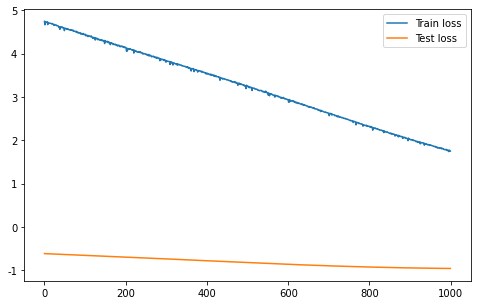

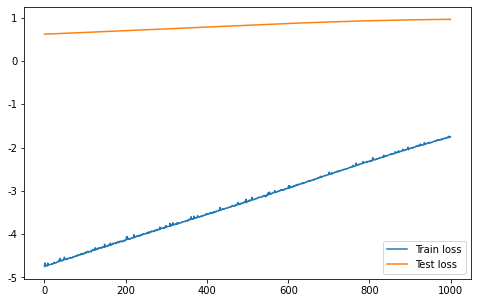

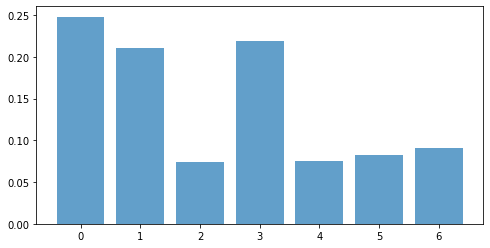

In [166]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') *100
xf_train = xf_train.astype('float32') *100
xc_test = xc_test.astype('float32') *100
xf_test = xf_test.astype('float32') *100


N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
#xc_train, xf_train = shuffle(xc_train, xf_train)

# Markowitz Network를 생성한다.
# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.07
REG_CONST = 0.0
SAVE_MODEL = 'data/3-1.MPN_LSTM.h5'

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# Markowitz Network에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)   # W = (None, 1, 50)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2) # R = (None, 50, 1)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_sum(objective, axis=0)


lstm = LSTM( units = 7, # units의 값은 layer 통일이 제일 효과적이다.
             input_shape=(N_TIME, N_STOCKS),  #(4980, 20, 5)  --> (20,5),    
             dropout=0.0,
             recurrent_dropout=0.0,
             return_sequences=False
      )
model = Sequential()
model.add( lstm )
model.add( Dense(N_STOCKS, activation='tanh') )
model.add(Activation('softmax'))


# 마코비츠의 최적 weights
with tf.device("/device:GPU:0"):
    #y_output = Activation('softmax')(y_output)

    
    model.compile(loss = markowitz_objective, 
                optimizer = Adam(learning_rate = 1e-5),
                )
    stop = EarlyStopping(patience=10, monitor='val_loss')

    model.summary()

    # MPN을 학습하고 결과를 저장한다.
    hist = model.fit(xc_train, xf_train, epochs=1000, batch_size = 64, 
                     #callbacks=[stop],
                    validation_data = (xc_test, xf_test))
    #model.save(SAVE_MODEL)

# loss trajectory를 확인한다.
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.negative(hist.history['loss']), label='Train loss')
plt.plot(np.negative(hist.history['val_loss']), label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 확인용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()
    
check_w(0)

# 백테스팅

In [167]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Markowitz's Portfolio Network (MPN)을 이용해서 최적 포트폴리오를 구축한다.
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 모델을 가져온다.
lstm_model = model

# MPN을 이용해서 백 테스트를 수행한다.
# --------------------------------
lstm_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_hist_lstm = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # LSTM으로 W를 추정한다.
    x = xc_test[i][np.newaxis,:, :]
    w_lstm = lstm_model.predict(x)[0]
    w_hist_lstm.append(w_lstm)
    
    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i]/100, axis = 0)
    
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    lstm_value.append(lstm_value[-1] * np.exp(np.dot(w_lstm, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    

print('\nBack test를 완료했습니다.')



Back test를 완료했습니다.


# 포트폴리오 성과 평가

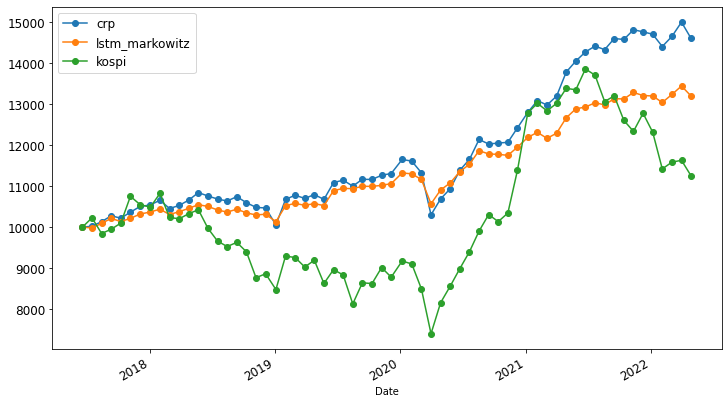

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_

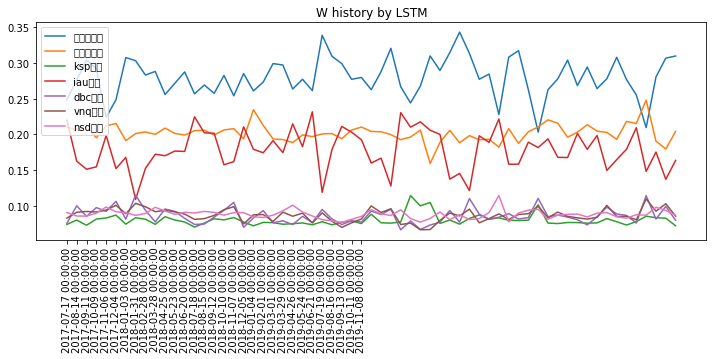


포트폴리오 수익률 (연간):
crp_rtn      0.072127
lstm_rtn     0.052862
sp500_rtn    0.022451
dtype: float64

포트폴리오 위험 (연간):
crp_rtn      0.022594
lstm_rtn     0.014581
sp500_rtn    0.047066
dtype: float64

Sharp Ratio :
crp_rtn      3.192322
lstm_rtn     3.625314
sp500_rtn    0.477018
dtype: float64


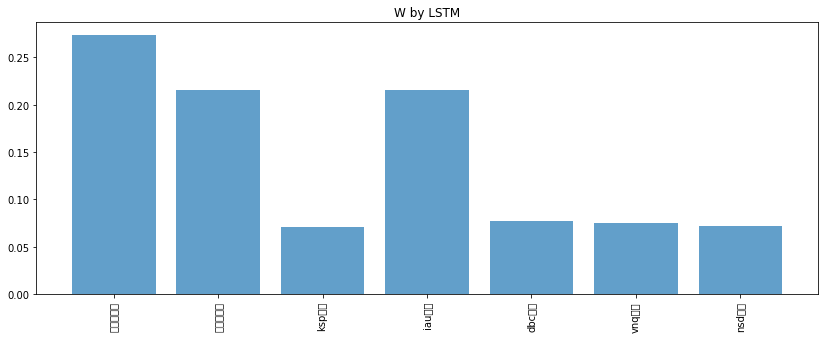

In [168]:
# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 
                        'lstm_markowitz':lstm_value
                        }, 
                       index=test_date[idx])

# S&P500 index와 포트폴리오 성과를 비교해 본다.
sp500 = pd.DataFrame(df3['코스피'])

# 수익률을 계산해서 perf_df와 시작 위치를 맞춘다 (초기 value를 맞춘다).
sp500 = sp500[test_date[0]:]
sp_trans = lstm_value[0] / sp500['코스피'][0]
perf_df['kospi'] = sp500['코스피'] * sp_trans

# S&P500 index (시장), CRP, 그리고 MPN의 성과를 비교한다.
p = perf_df.plot(figsize=(12, 7), style = '-o', fontsize=12)
p.legend(fontsize=12)
##그래프저장
plt.show()

# weights history를 확인한다.
w_hist_lstm = np.array(w_hist_lstm)

# 종목 이름을 읽어온다.
symbol = rtn_df.columns

n = 7
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.plot(w_hist_lstm[:, i], label=symbol[i])
plt.legend(loc='upper left')
plt.title('W history by LSTM')
plt.xticks(np.arange(0, 31), list(perf_df.index[1:]), rotation='vertical')
plt.show()

# 포트폴리오 수익률, 위험, SR을 측정한다.
rp_df = perf_df.copy()
rp_df['crp_rtn'] = np.log(rp_df['crp']) - np.log(rp_df['crp'].shift(1))
rp_df['lstm_rtn'] = np.log(rp_df['lstm_markowitz']) - np.log(rp_df['lstm_markowitz'].shift(1))
rp_df['sp500_rtn'] = np.log(rp_df['kospi']) - np.log(rp_df['kospi'].shift(1))
rp_df = rp_df.dropna()

# 포트폴리오 수익률 (연간)
rp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].mean()
# 20일 = 약 1개월, 1년 = 12개월
rp*=12
print('\n포트폴리오 수익률 (연간):')
print(rp)

# 포트폴리오 위험 (연간 표준편차)
sp = rp_df[['crp_rtn', 'lstm_rtn', 'sp500_rtn']].std()
print('\n포트폴리오 위험 (연간):')
print(sp)

# Sharp ratio
print('\nSharp Ratio :')
print(rp / sp)

# 최적 포트폴리오 결과 확인용 코드 (참고용)
def check_w(n = 0):
    plt.figure(figsize=(14,5))
    x = xc_test[n][np.newaxis,:,:] * 20.0
    w_lstm = lstm_model.predict(x)[0]
    plt.bar(np.arange(N_STOCKS), w_lstm, alpha = 0.7)
    plt.xticks(np.arange(7), list(symbol), rotation='vertical')
    plt.title('W by LSTM')
    plt.show()
    
check_w(0)

## 가중치 DF 저장 (일자별)

In [169]:
w_hist_lstm = []
for i in range(0, xc_test.shape[0]):
    # LSTM으로 W를 추정한다.
    x = xc_test[i][np.newaxis,:, :]
    w_lstm = lstm_model.predict(x)[0]
    w_hist_lstm.append(w_lstm)


In [170]:
idx = np.arange(0, len(test_date))
date=test_date[idx]

In [171]:
len(w_hist_lstm)

1250

In [172]:
W_df=pd.DataFrame(w_hist_lstm[:-1],columns=rtn_df.columns,index=list(date)[20:])
W_df

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
2017-07-17,0.248153,0.210410,0.073695,0.219609,0.075302,0.082481,0.090351
2017-07-18,0.227940,0.203271,0.076189,0.241344,0.073712,0.080968,0.096576
2017-07-19,0.222446,0.209552,0.075894,0.239655,0.077632,0.081715,0.093106
2017-07-20,0.226576,0.212583,0.075920,0.236395,0.080172,0.080961,0.087392
2017-07-21,0.235348,0.212348,0.078799,0.218176,0.088236,0.082936,0.084156
...,...,...,...,...,...,...,...
2022-05-04,0.277195,0.201183,0.075675,0.195841,0.078060,0.082164,0.089883
2022-05-05,0.289069,0.192017,0.075364,0.202906,0.076144,0.078666,0.085834
2022-05-06,0.295693,0.214035,0.068802,0.177236,0.075996,0.083390,0.084849
2022-05-09,0.312471,0.198922,0.077140,0.151515,0.088095,0.087959,0.083898


In [173]:
W_df.to_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/하락/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치(일자별).csv")


# 타 펀드 비교(KB)

In [174]:
kb=pd.read_excel("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/kb아무것도못하쥬.xlsx")
kb.일자=pd.to_datetime(kb.일자)
kb=kb.set_index('일자')
#일자설정
kb=kb.loc[perf_df.index[0]:perf_df.index[-1]]
kb['금액']=10000
kb['수익률(%)']=kb['수익률(%)']*0.01
for i in range(1,kb.shape[0]):
    kb.iloc[i,1]=kb.iloc[i,0]*kb.iloc[i-1,1]+kb.iloc[i-1,1]
p_df=perf_df.copy()
p_df=p_df.reset_index()
kb=kb.reset_index()
grp=pd.merge(p_df,kb,left_on='Date',right_on='일자',how='outer')
grp=grp.set_index('Date')
grp=grp[['crp', 'lstm_markowitz', 'kospi', '금액']]
grp.columns=['crp', 'lstm_markowitz', 'kospi', 'KB펀드']
grp=grp.dropna()

# 타 펀드 비교 <미래에셋>

In [175]:
fa=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/미래에셋.csv")
fa=fa.T
fa=fa.iloc[1:]
fa=fa.reset_index()
fa['index']=pd.to_datetime(fa['index'])
fa=fa.set_index('index')
fa.columns=['투자수익률','비교지수']
fa['미래에셋']=fa['투자수익률']*0.01*10000+10000
fa['미래에셋_pct']=fa['미래에셋'].pct_change(1)
#일자설정
fa=fa.loc[perf_df.index[0]:perf_df.index[-1]]
fa['미래에셋']=10000
for i in range(1,fa.shape[0]):
    fa.iloc[i,2]=fa.iloc[i,3]*fa.iloc[i-1,2]+fa.iloc[i-1,2]
fa=fa.reset_index()
fa['index']=pd.to_datetime(fa['index'])
grp=pd.merge(grp.reset_index(),fa[['index','미래에셋']],left_on='Date',right_on='index',how='outer')
grp=grp[['Date','lstm_markowitz','kospi','미래에셋','KB펀드']]
grp=grp.dropna()
grp=grp.set_index('Date')

# 차트 이미지 저장

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49483 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_

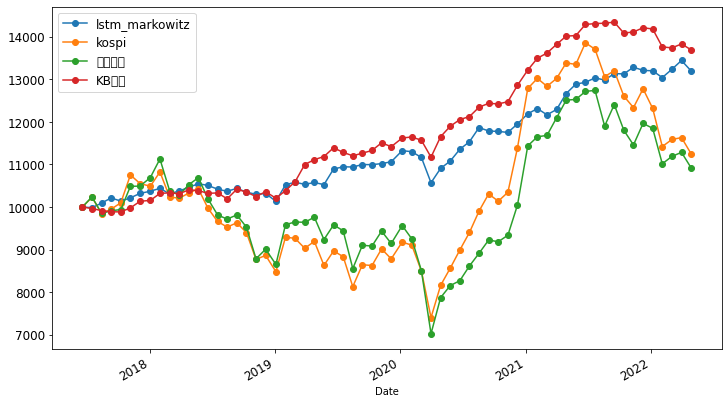

In [176]:
p = grp.plot(figsize=(12, 7), style = '-o', fontsize=12)
p.legend(fontsize=12)
plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/하락/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

# 주식 전략 결합

In [ ]:
log_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/최종데이터셋.csv")

In [ ]:
log_df = log_df.set_index('Date')
log_df = log_df.loc[:'2019-10-31']

In [ ]:
log_df

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,상승,코스피
Date,,,,,,,,,
2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493,0,1371.589966
2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,0,1367.699951
2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,0,1328.949951
2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0,1344.760010
2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,0,1316.670044
...,...,...,...,...,...,...,...,...,...
2019-10-25,0.000004,-0.001182,0.001069,0.002085,0.005782,-0.008568,-0.025676,0,2087.889893
2019-10-28,0.000081,-0.002041,0.002731,-0.009069,-0.003851,-0.006074,0.003043,0,2093.600098
2019-10-29,0.000023,0.001165,-0.000435,-0.003510,-0.001931,0.006074,-0.000912,0,2092.689941


In [ ]:
log_df = log_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그',
       'vnq로그', 'nsd로그']]

In [ ]:
log_df.to_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/log데이터셋.csv")

In [ ]:
log_df = pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/log데이터셋.csv")

In [ ]:
log_df['Date']=pd.to_datetime(log_df['Date'])

In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그'], dtype='object')

In [ ]:
r_df=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/주식전략/로그수익률전체_10종목.csv")

In [ ]:
r_df=r_df.fillna(0)

In [ ]:
r_df.columns

Index(['Unnamed: 0', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법'],
      dtype='object')

In [ ]:
r_df['Unnamed: 0']=pd.to_datetime(r_df['Unnamed: 0'])
r_df.columns=['Date', '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']


## 극안전형

In [ ]:
극안전형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/극안전형.csv")
안전추구형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/안전추구형.csv")
위험중립형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/위험중립형.csv")
적극투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/적극투자형.csv")
공격투자형=pd.read_csv("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/비중DF/투자유형비중총결합/공격투자형.csv")

In [ ]:
극안전형 = 극안전형.drop('Unnamed: 0', axis=1)
극안전형.columns = ['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그']

In [ ]:
극안전형

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2019-11-01,0.357846,0.350863,0.062167,0.075185,0.050869,0.051566,0.051505
1,2019-11-04,0.355070,0.349667,0.060141,0.084932,0.049446,0.050332,0.050412
2,2019-11-05,0.354140,0.348552,0.058575,0.088817,0.049258,0.050139,0.050519
3,2019-11-06,0.357363,0.350958,0.059128,0.081139,0.049868,0.050622,0.050922
4,2019-11-07,0.357707,0.352224,0.059453,0.079134,0.049905,0.050711,0.050866
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.321213,0.324599,0.059282,0.146375,0.047149,0.050200,0.051183
650,2022-05-05,0.321733,0.328054,0.062213,0.138679,0.047262,0.050574,0.051485
651,2022-05-06,0.341676,0.338979,0.058035,0.110634,0.048454,0.051089,0.051133
652,2022-05-09,0.346246,0.340667,0.064234,0.096437,0.049179,0.051808,0.051428


In [ ]:
극안전형.Date=pd.to_datetime(극안전형.Date)


In [ ]:
극안전형_df=pd.concat([log_df,극안전형], axis=0)
극안전형_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그
0,2006-03-01,0.000000,0.000000,0.000000,0.001961,-0.002149,0.005808,-0.000493
1,2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176
2,2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103
3,2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103
4,2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212
...,...,...,...,...,...,...,...,...
649,2022-05-04,0.321213,0.324599,0.059282,0.146375,0.047149,0.050200,0.051183
650,2022-05-05,0.321733,0.328054,0.062213,0.138679,0.047262,0.050574,0.051485
651,2022-05-06,0.341676,0.338979,0.058035,0.110634,0.048454,0.051089,0.051133
652,2022-05-09,0.346246,0.340667,0.064234,0.096437,0.049179,0.051808,0.051428


In [ ]:
#기간별로 정렬
극안전형_df=극안전형_df.sort_values(by=['Date'], ascending=True)

In [ ]:
극안전형_df=극안전형_df.fillna(method='ffill').dropna()

In [ ]:
극안전형_df=pd.merge(극안전형_df,r_df, on='Date', how='outer').dropna()

In [ ]:
극안전형_df = 극안전형_df.set_index('Date')

In [ ]:
극안전형_df

,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,유동성기법,레버리지기법,그레이엄기법,린치기법,버핏기법,삼대투자기법,성장성기법,수익성기법,시장가치기법,활동성기법
Date,,,,,,,,,,,,,,,,,
2006-03-02,0.000263,-0.000102,-0.002840,0.011332,0.017911,-0.001220,-0.012176,-0.004163,0.003148,-0.004245,-0.009235,-0.004180,-0.002885,-0.011703,0.003138,0.001468,0.007272
2006-03-03,0.000105,0.000438,-0.028741,-0.007067,0.009256,-0.005508,0.017103,-0.016589,-0.022778,-0.017546,-0.022754,-0.024339,-0.019855,-0.019931,-0.023816,-0.042204,-0.022764
2006-03-06,0.000326,-0.000830,0.011826,-0.018973,-0.016041,0.017942,-0.018103,0.011637,0.011190,0.004478,0.003144,0.012759,0.010315,0.011755,0.010877,0.021549,0.014470
2006-03-07,0.000094,-0.000840,-0.021110,-0.005072,-0.017601,-0.012129,-0.043212,-0.016843,-0.028491,-0.011694,-0.002772,-0.025226,-0.013850,-0.019911,-0.026519,-0.021908,-0.025480
2006-03-08,0.000203,0.000818,-0.001992,-0.019625,-0.016154,0.005173,0.007549,-0.007919,-0.004598,0.010290,0.001887,-0.014189,-0.006048,-0.010333,-0.003670,0.000692,-0.003637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,0.330887,0.330873,0.062915,0.125514,0.047841,0.050911,0.051060,0.002114,-0.006505,-0.008353,-0.003740,0.001091,-0.004454,-0.004513,-0.006798,-0.001810,-0.008891
2022-05-04,0.321213,0.324599,0.059282,0.146375,0.047149,0.050200,0.051183,-0.009320,-0.003745,-0.006407,0.001788,-0.004029,-0.000976,0.000924,-0.002858,0.006830,0.002055
2022-05-06,0.341676,0.338979,0.058035,0.110634,0.048454,0.051089,0.051133,0.001078,-0.013734,-0.006216,-0.013486,-0.012977,-0.015054,-0.014405,-0.012405,-0.008364,-0.006202


In [ ]:
극안전형_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그','유동성기법', '레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']]=극안전형_df[['단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그','유동성기법','레버리지기법','그레이엄기법', '린치기법', '버핏기법', '삼대투자기법',
       '성장성기법', '수익성기법', '시장가치기법', '활동성기법']].cumsum()

In [ ]:
극안전형_df['금액']=10000

In [ ]:
극안전형_df

,Date,단기채로그,중기채로그,ksp로그,iau로그,dbc로그,vnq로그,nsd로그,유동성기법,레버리지기법,...,시장가치기법,활동성기법,단기채w,중기채w,kspw,iauw,dbcw,vnqw,nsdw,금액
0,2019-11-01,0.357846,0.350863,0.062167,0.075185,0.050869,0.051566,0.051505,0.000157,0.014511,...,0.008100,0.014093,0.357846,0.350863,0.062167,0.075185,0.050869,0.051566,0.051505,10000
1,2019-11-04,0.712916,0.700531,0.122307,0.160117,0.100315,0.101897,0.101917,0.014559,0.017529,...,0.016869,0.033270,0.355070,0.349667,0.060141,0.084932,0.049446,0.050332,0.050412,10000
2,2019-11-05,1.067056,1.049082,0.180882,0.248934,0.149573,0.152037,0.152436,0.029178,0.017005,...,0.027458,0.038091,0.354140,0.348552,0.058575,0.088817,0.049258,0.050139,0.050519,10000
3,2019-11-06,1.424418,1.400040,0.240010,0.330073,0.199441,0.202659,0.203359,0.028046,0.012199,...,0.029495,0.034984,0.357363,0.350958,0.059128,0.081139,0.049868,0.050622,0.050922,10000
4,2019-11-07,1.782125,1.752264,0.299463,0.409208,0.249346,0.253370,0.254225,0.029493,0.013177,...,0.034695,0.042584,0.357707,0.352224,0.059453,0.079134,0.049905,0.050711,0.050866,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,2022-05-03,146.648074,156.564560,45.243843,108.555898,33.600930,50.255897,81.130798,-0.164537,-0.030700,...,0.434623,0.034518,0.340171,0.332817,0.053358,0.132273,0.047174,0.047073,0.047136,10000
619,2022-05-04,146.969286,156.889159,45.303126,108.702273,33.648079,50.306097,81.181981,-0.173857,-0.034445,...,0.441454,0.036573,0.340171,0.332817,0.053358,0.132273,0.047174,0.047073,0.047136,10000
620,2022-05-06,147.310963,157.228137,45.361161,108.812906,33.696533,50.357186,81.233114,-0.172779,-0.048179,...,0.433090,0.030371,0.340171,0.332817,0.053358,0.132273,0.047174,0.047073,0.047136,10000
621,2022-05-09,147.657208,157.568805,45.425395,108.909344,33.745712,50.408994,81.284542,-0.189689,-0.059794,...,0.419654,0.023748,0.340171,0.332817,0.053358,0.132273,0.047174,0.047073,0.047136,10000


In [ ]:
log_df['유동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['유동성기법'])
log_df['레버리지']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['레버리지기법'])
log_df['그레이엄']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['그레이엄기법'])
log_df['린치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['린치기법'])
log_df['버핏']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['버핏기법'])
log_df['삼대투자']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['삼대투자기법'])
log_df['성장성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['성장성기법'])
log_df['수익성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['수익성기법'])
log_df['시장가치']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['시장가치기법'])
log_df['활동성']=log_df['금액']*log_df['단기채w']*np.exp(log_df['단기채로그'])+log_df['금액']*log_df['중기채w']*np.exp(log_df['중기채로그'])+log_df['금액']*log_df['iauw']*np.exp(log_df['iau로그'])+log_df['금액']*log_df['dbcw']*np.exp(log_df['dbc로그'])+log_df['금액']*log_df['vnqw']*np.exp(log_df['vnq로그'])+log_df['금액']*log_df['nsdw']*np.exp(log_df['nsd로그'])+log_df['금액']*log_df['kspw']*np.exp(log_df['활동성기법'])



In [ ]:
log_df.columns

Index(['Date', '단기채로그', '중기채로그', 'ksp로그', 'iau로그', 'dbc로그', 'vnq로그', 'nsd로그',
       '유동성기법', '레버리지기법', '그레이엄기법', '린치기법', '버핏기법', '삼대투자기법', '성장성기법', '수익성기법',
       '시장가치기법', '활동성기법', '단기채w', '중기채w', 'kspw', 'iauw', 'dbcw', 'vnqw',
       'nsdw', '금액', '유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자', '성장성', '수익성',
       '시장가치', '활동성'],
      dtype='object')

In [ ]:
grp = grp.drop(['level_0', 'index'], axis=1)

In [ ]:
grp=pd.merge(grp,log_df[['Date','유동성', '레버리지', '그레이엄', '린치', '버핏', '삼대투자',
       '성장성', '수익성', '시장가치', '활동성']],on='Date',how='outer').dropna()

In [ ]:
grp

,Date,lstm_markowitz,kospi,미래에셋,KB펀드,금액,유동성_x,레버리지_x,그레이엄_x,린치_x,...,유동성,레버리지,그레이엄,린치,버핏,삼대투자,성장성,수익성,시장가치,활동성
0,2019-11-01,10187.362432,10393.479515,10227.294524,10080.015967,10000.0,10005.633421,10014.622593,10011.265371,10008.849871,...,1.315413e+04,1.316312e+04,1.315976e+04,1.315734e+04,1.316140e+04,1.315880e+04,1.315901e+04,1.316230e+04,1.315909e+04,1.316285e+04
1,2019-11-29,10334.183163,10332.906193,10208.113551,10171.523403,10000.0,10007.633854,9997.061891,10006.098425,10008.513379,...,1.208665e+07,1.208664e+07,1.208665e+07,1.208665e+07,1.208665e+07,1.208663e+07,1.208666e+07,1.208665e+07,1.208667e+07,1.208666e+07
2,2019-12-30,10554.629758,10875.839370,10873.693296,10341.156641,10000.0,10107.852540,10109.586143,10135.190078,10119.390367,...,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10,1.397621e+10
3,2020-01-28,10723.319220,10772.162152,10450.752853,10398.571566,10000.0,10144.402212,10153.875840,10132.090062,10102.381538,...,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13,1.735655e+13
4,2020-02-25,10996.476872,10410.355712,9849.429366,10309.944928,10000.0,10157.752961,10181.030486,10125.822446,10109.267991,...,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16,2.216353e+16
5,2020-03-24,7480.303458,7967.427054,7047.089287,9519.046916,10000.0,9618.630957,9643.519709,9553.747163,9547.239428,...,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19,1.600964e+19


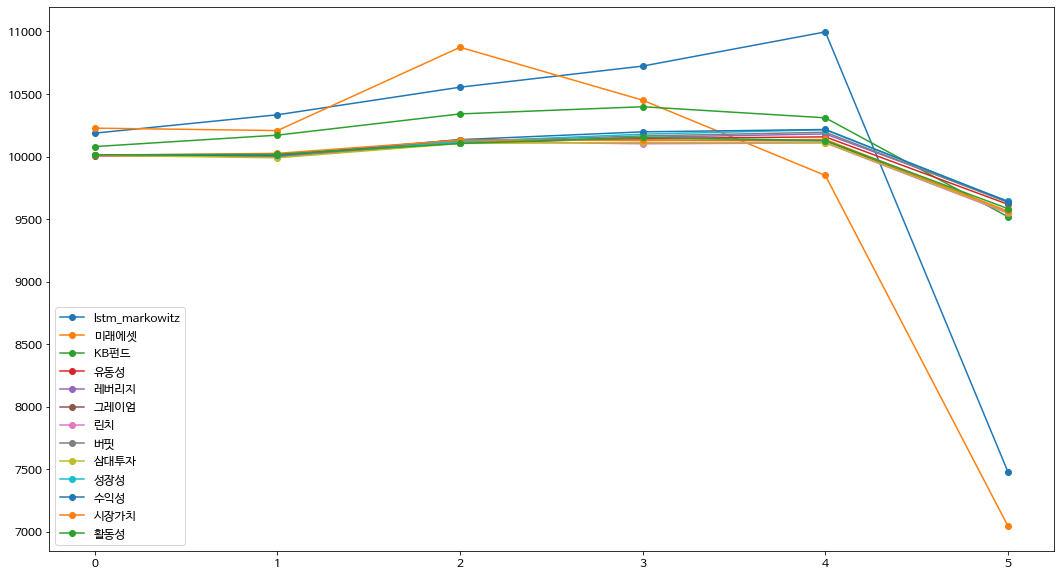

In [ ]:
p = grp[['lstm_markowitz', '미래에셋', 'KB펀드', '유동성',
       '레버리지', '그레이엄', '린치', '버핏', '삼대투자', '성장성', '수익성', '시장가치', '활동성']].plot(figsize=(18, 10), style = '-o', fontsize=12)
p.legend(fontsize=12)
plt.savefig("/content/gdrive/My Drive/FINAL TEAM/파이널프로젝트/비주식팀/Data/차트/기간"+str(perf_df.index[1])[:10]+"-"+str(perf_df.index[-1])[:10]+"감마"+str(GAMMA_CONST)+"REG"+str(REG_CONST)+"가중치.png")
plt.show()

In [ ]:
grp

,crp,lstm_markowitz,kospi,미래에셋,KB펀드
Date,,,,,
2019-12-31,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
2020-01-29,10036.938181,10224.825144,9943.622596,9629.564297,10001.226413
2020-02-26,10005.999563,10295.900080,9449.872335,8954.842124,10003.711958
2020-03-25,8402.684397,8137.672903,7757.124911,6931.557594,9384.491606
2020-04-22,9057.310134,8708.347455,8628.001892,7832.951138,9915.377562
2020-05-20,9362.758662,9051.162397,9053.406951,8273.064032,10137.949590
2020-06-17,9824.690125,9496.075493,9742.364072,8539.424943,10302.839218
2020-07-15,9957.452690,9693.330050,10019.156475,8721.114835,10403.527375
2020-08-12,10371.504093,10128.862742,11067.859069,9440.818487,10647.166535
